## 0. Preparing environment

#### Importing machine learning and data processing modules

In [1]:
import os
import pandas as pd; pd.set_option('max_colwidth', None)
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from IPython.display import clear_output as co

from sklearn.preprocessing import binarize 
import sklearn.metrics as metrics
from sklearn.utils import all_estimators
classifiers = dict(all_estimators('classifier'))
from sklearn.model_selection import cross_validate as CV, learning_curve as lc

#### Defining scoring functions
recall_0 = metrics.make_scorer(metrics.recall_score, pos_label=0)
recall_1 = metrics.make_scorer(metrics.recall_score, pos_label=1)
precision_0 = metrics.make_scorer(metrics.precision_score, pos_label=0)
precision_1 = metrics.make_scorer(metrics.precision_score, pos_label=1)
scoring = {'accuracy': 'accuracy', 'f1_macro': 'f1_macro',
           'recall_macro': 'recall_macro', 'precision_macro': 'precision_macro',
           'recall_0': recall_0, 'recall_1': recall_1,
           'precision_0': precision_0, 'precision_1': precision_1,
          }

In [1]:
from sklearn.metrics import classification_report as cr
from imblearn.under_sampling import RandomUnderSampler

from Classification import Classifier, plot_lc_model_comparison
from NeuralNetwork import execute_neural_net, plot_learning_curve_comparison

### 0.1 Import custom (authoral) sampling class

In [11]:
from splitter import UnderSampleSplit
from cv_samplers import print_cls_cnt

---
# 1. LOAD DATA

In [5]:
data = pd.read_csv('data/grades/5th_grade.csv', index_col=0)
data.drop('ID_ALUNO', 1, inplace=True)

# Loading data information dictionaries
data_path = '/Users/luisr/Desktop/Repositories/Data/saep/CSV/{}'
grades = [5,9,3]; dict_filenames = [f'dicionario {i}ano.csv' for i in grades]
dicts = {grade: pd.read_csv(data_path.format(filename)).set_index('questão') for grade, filename in zip(grades, dict_filenames)}

#### Defining targets corresponding to each student grade
targets = { # Abandonment
    5: 'TX_RESP_Q049',
    9: 'TX_RESP_Q050',
    12: 'TX_RESP_Q044',
}
grade = 5
target = targets[grade]

#### List different types of features
ids = data.columns[:10].tolist()
questions = data.columns[10:64].tolist()
grades = data.columns[64:].tolist()

---
# 2. DATA TRANSFORMATION
### Binarize target & fill missing values

In [6]:
# eliminate rows where the target variable value is missing. obs: last label represent missing values (Label 3)
modeling_data = data[data[target]!=data[target].max()].copy()
# target variable binary conversion
modeling_data[target] = binarize(modeling_data[[target]], threshold=0.5).reshape(-1)

# define X and Y
Y = modeling_data[target].reset_index(drop=True).copy()
X = modeling_data.reset_index(drop=True).drop(target, 1)

# FILLING MISSING VALUES WITH VARIABLES' MEANS
for grade in grades:
    X[grade].fillna(X[grade].mean(), inplace=True)
    
# target variable class count
print(Y.value_counts())

0    397232
1     50087
Name: TX_RESP_Q049, dtype: int64


---
# 3. CLASSIFICATION MODELING

#### Compare performance of different:
* Models
* Random train splits
* Target variable class ratios
* Train sizes (Learning curve)
* Model hyperparameters

In [7]:
def cv_df(cv_res, scoring):
    return pd.DataFrame({scr: cv_res['test_'+scr] for scr in scoring})

## 3.1 Sampling

#### Representative imbalanced test sample

In [52]:
uss = UnderSampleSplit()

test_index, left_index = uss.undersample(
    Y, train_size=0.5, train_prct=3,
    replace=False, shuffle=True,
    random_state=0
)

In [53]:
print_cls_cnt(Y, test_index, left_index)

,Train set,Test set
Class,,
0,75132,322100
1,25044,25043


#### Balanced train test sample

In [54]:
uss = UnderSampleSplit(
    train_size=0.08, train_prct=1,
    test_size=0.5, test_prct=1,
    replace=False, shuffle=True,
    random_state=0
)
train_index, _left_index = uss.train_test_undersample(Y.loc[left_index], random_state=0)
xt, xe, yt, ye = X.loc[train_index], X.loc[test_index], Y.loc[train_index], Y.loc[test_index], 
print_cls_cnt(Y, train_index, left_index)

,Train set,Test set
Class,,
0,2003,322100
1,2003,25043


#### Balanced cross validation split samples

In [55]:
cv = uss.split(Y.loc[left_index], n_splits=5, param_list=None)
for i in range(5): cv[i] = (cv[i][0], test_index)

In [56]:
print_cls_cnt(Y, cv[0][0], cv[0][1])

,Train set,Test set
Class,,
0,2003,75132
1,2003,25044


## Compare train splits (same test split)

In [60]:
modelname = 'GradientBoostingClassifier'# 'GradientBoostingClassifier', 'DecisionTreeClassifier', 'LinearSVC', 'LogisticRegression',
Model = classifiers[modelname]
model = Model(n_estimators=100, random_state=0)

#### score cross validation splits

In [ ]:
model_scrs = CV(
    model, X, Y, cv=cv,
    scoring=scoring,
    groups=None,
    n_jobs=-1,
    pre_dispatch='all',
    verbose=5
)

In [ ]:
scrs_df = pd.DataFrame({scr: model_scrs['test_'+scr] for scr in scoring})
scrs_df.mean()

## Shuffle splits' learning curves 

In [352]:
order=3
train_sizes = np.linspace(0.1, 1, 11)**order
lc_0, lc_1 = ( lc(
    model,
    X, Y,
    train_sizes=train_sizes,
    cv=cv,
    scoring=[recall_0, recall_1][i],
    groups=None,
    random_state=0,
    shuffle=True,
    verbose=5,
    n_jobs=-1,
    pre_dispatch='all',
    error_score='raise'
) for i in (0, 1) )

[learning_curve] Training set sizes: [   4   30   98  228  438  750 1181 1753 2485 3397 4508]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  55 | elapsed:    2.2s remaining:   13.6s
[Parallel(n_jobs=-1)]: Done  20 out of  55 | elapsed:    6.1s remaining:   10.7s
[Parallel(n_jobs=-1)]: Done  32 out of  55 | elapsed:   10.1s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done  44 out of  55 | elapsed:   14.3s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   18.6s finished


[learning_curve] Training set sizes: [   4   30   98  228  438  750 1181 1753 2485 3397 4508]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  55 | elapsed:    4.6s remaining:   27.3s
[Parallel(n_jobs=-1)]: Done  20 out of  55 | elapsed:    8.5s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done  32 out of  55 | elapsed:   11.7s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  44 out of  55 | elapsed:   15.0s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   18.9s finished


### Recall - minority class

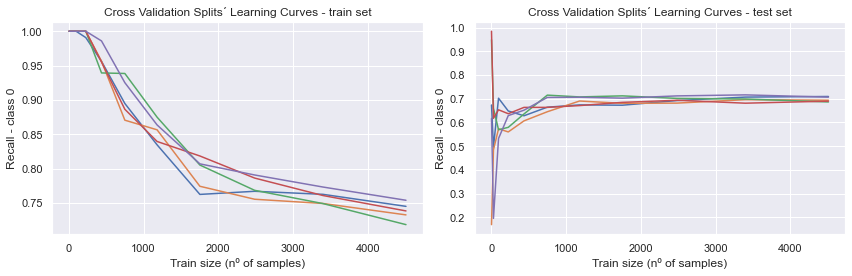

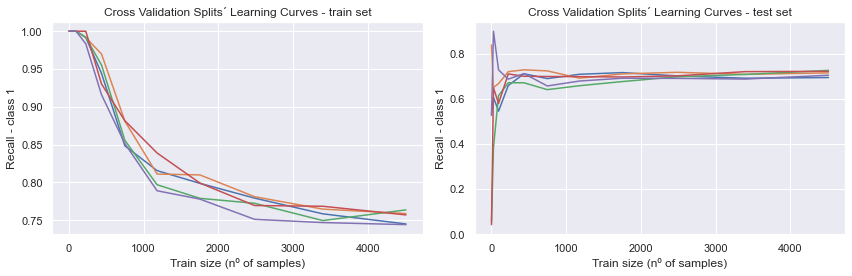

In [353]:
for lc_df, cls_label in zip([lc_0, lc_1], ['class 0', 'class 1']):
    train_lc, test_lc = (pd.DataFrame(lc_df[i], index=lc_df[0]) for i in [1,2])
    fig, ax = plt.subplots(1,2, figsize=(12,4), tight_layout=True)
    ax[0].plot(train_lc)
    ax[1].plot(test_lc)
    for i, label in zip([0,1], ['train set', 'test set']):
        ax[i].set(
            title=f'Cross Validation Splits´ Learning Curves - {label}',
            ylabel=f'Recall - {cls_label}',
            xlabel='Train size (nº of samples)'
        )
    plt.show()

Conclusions:
* Recall for both classes roughly optimized after 1500 samples of each class

# Performance for varying majority/minority class ratio in train set

## Sampling
#### Set varying class ratio split params

#### Balanced cross validation split samples

In [280]:
n_splits = 11
max_prct = 3 # max majority/minority size
order = 2

param_values = max_prct * np.linspace(0.1, 1, n_splits)**order
param_list = [{
    'train_size': 0.05,
    'train_prct': train_prct,
    'test_size': None,
    'test_prct': None,

} for train_prct in param_values]

cv = uss.split(Y.loc[left_index], n_splits=n_splits, param_list=param_list)
for i in range(n_splits): cv[i] = (cv[i][0], test_index) # make splits share test index
print_cls_cnt(Y, cv[0][0], cv[0][1])
print_cls_cnt(Y, cv[-1][0], cv[-1][1])

,Train set,Test set
Class,,
0,68,20036
1,2254,5009


,Train set,Test set
Class,,
0,6762,20036
1,2254,5009


## Defining models

In [324]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.ensemble import (
    EasyEnsembleClassifier as EEC, RUSBoostClassifier as RUSBC,
    BalancedBaggingClassifier as BBC, BalancedRandomForestClassifier as BRFC
)
GBC = classifiers['GradientBoostingClassifier']
RFC = classifiers['RandomForestClassifier']
BC = classifiers['BaggingClassifier']

models = [model(n_estimators=60) for model in (BC, RFC, GBC, EEC, BBC, BRFC, RUSBC)]

## Cross validation grid search pipeline: Ensemble classifiers comparison

In [326]:
pipe = Pipeline([('model', None)])
param_grid = {'model': models}

In [328]:
grid_search = GridSearchCV(
    pipe, param_grid,
    cv=cv, scoring=scoring,
    refit='recall_macro',
    n_jobs=-1, 
    pre_dispatch='all',
    verbose=4
)

In [329]:
search_fit = grid_search.fit(X, Y)

Fitting 11 folds for each of 7 candidates, totalling 77 fits


In [381]:
search_res = pd.DataFrame(search_fit.cv_results_); search_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,split5_test_accuracy,split6_test_accuracy,split7_test_accuracy,split8_test_accuracy,split9_test_accuracy,split10_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,split3_test_f1_macro,split4_test_f1_macro,split5_test_f1_macro,split6_test_f1_macro,split7_test_f1_macro,split8_test_f1_macro,split9_test_f1_macro,split10_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro,split0_test_recall_macro,split1_test_recall_macro,split2_test_recall_macro,split3_test_recall_macro,split4_test_recall_macro,split5_test_recall_macro,split6_test_recall_macro,split7_test_recall_macro,split8_test_recall_macro,split9_test_recall_macro,split10_test_recall_macro,mean_test_recall_macro,std_test_recall_macro,rank_test_recall_macro,split0_test_precision_macro,split1_test_precision_macro,...,split6_test_recall_0,split7_test_recall_0,split8_test_recall_0,split9_test_recall_0,split10_test_recall_0,mean_test_recall_0,std_test_recall_0,rank_test_recall_0,split0_test_recall_1,split1_test_recall_1,split2_test_recall_1,split3_test_recall_1,split4_test_recall_1,split5_test_recall_1,split6_test_recall_1,split7_test_recall_1,split8_test_recall_1,split9_test_recall_1,split10_test_recall_1,mean_test_recall_1,std_test_recall_1,rank_test_recall_1,split0_test_precision_0,split1_test_precision_0,split2_test_precision_0,split3_test_precision_0,split4_test_precision_0,split5_test_precision_0,split6_test_precision_0,split7_test_precision_0,split8_test_precision_0,split9_test_precision_0,split10_test_precision_0,mean_test_precision_0,std_test_precision_0,rank_test_precision_0,split0_test_precision_1,split1_test_precision_1,split2_test_precision_1,split3_test_precision_1,split4_test_precision_1,split5_test_precision_1,split6_test_precision_1,split7_test_precision_1,split8_test_precision_1,split9_test_precision_1,split10_test_precision_1,mean_test_precision_1,std_test_precision_1,rank_test_precision_1
0,8.790089,4.696368,1.883661,0.180781,BaggingClassifier(n_estimators=60),{'model': BaggingClassifier(n_estimators=60)},0.201158,0.265003,0.346097,0.484967,0.581793,0.639848,0.710042,0.748812,0.775484,0.791815,0.803833,0.577168,0.210750,6,0.168575,0.252673,0.345217,0.475867,0.551758,0.591896,0.631733,0.646709,0.650110,0.638146,0.618178,0.506442,0.165332,6,0.499900,0.534488,0.575140,0.634233,0.666376,0.678404,0.677131,0.666026,0.650504,0.626273,0.602266,0.619158,0.057344,6,0.492141,0.583064,...,0.731982,0.804003,0.858804,0.902176,0.938211,0.549175,0.322334,6,0.997804,0.983629,0.956878,0.883011,0.807347,0.742663,0.622280,0.528050,0.442204,0.350369,0.266321,0.689141,0.251006,2,0.784314,0.954241,0.947201,0.929474,0.916029,0.905179,0.885735,0.872029,0.860307,0.847445,0.836470,0.885311,0.049260,7,0.199968,0.211887,0.228739,0.264281,0.298384,0.324862,0.367268,0.402465,0.439136,0.472409,0.518663,0.338915,0.104450,5
1,1.633058,0.676339,0.617569,0.117878,RandomForestClassifier(n_estimators=60),{'model': RandomForestClassifier(n_estimators=60)},0.200040,0.214334,0.289758,0.419685,0.562148,0.655620,0.719705,0.772010,0.790697,0.804272,0.808664,0.566994,0.232684,7,0.166722,0.186558,0.282395,0.418325,0.537686,0.602734,0.638591,0.654820,0.643379,0.619405,0.583588,0.484927,0.180352,7,0.500025,0.508135,0.547714,0.610426,0.662707,0.682347,0.680400,0.660012,0.632911,0.603289,0.574291,0.605660,0.062855,7,0.600004,0.586886,...,0.745907,0.846676,0.895887,0.938261,0.964913,0.541217,0.358898,7,1.000000,0.997804,0.977640,0.928329,0.830305,0.726892,0.614893,0.473348,0.369934,0.268317,0.183669,0.670103,0.291747,5,1.000000,0.971129,0.954693,0.942283,0.921077,0.903301,0.885682,0.865422,0.850469,0.836850,0.825421,0.905121,0.055111,1,0.200008,0.202644,0.216941,0.247012,0.291349,0.334098,0.376943,0.435605,0.470424,0.520728,0.566852,0.

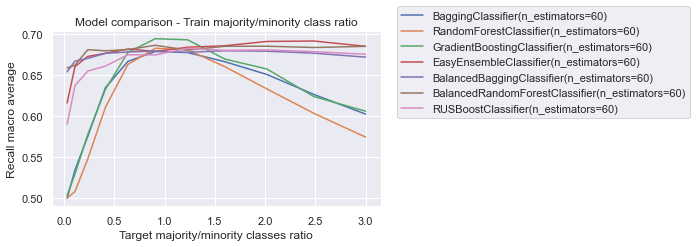

In [382]:
ratio_cols = [f'split{i}_test_recall_macro' for i in range(n_splits)]
ratio_scrs = search_res.set_index('param_model')[ratio_cols].T.set_index(param_values)

fig, ax = plt.subplots(figsize=(10, 3.5), tight_layout=True)
ratio_scrs.plot(ax=ax)
ax.set(
    title='Model comparison - Train majority/minority class ratio',
    xlabel='Target majority/minority classes ratio',
    ylabel='Recall macro average'
)
ax.legend(loc=(1.05, 0.5))
plt.show()

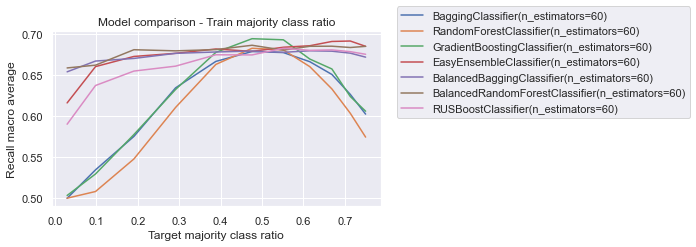

In [383]:
ratio_cols = [f'split{i}_test_recall_macro' for i in range(n_splits)]
ratio_scrs = search_res.set_index('param_model')[ratio_cols].T.set_index(param_values)

fig, ax = plt.subplots(figsize=(10, 3.5), tight_layout=True)
ax.plot(param_values/(1+param_values), ratio_scrs)
ax.set(
    title='Model comparison - Train majority class ratio',
    xlabel='Target majority class ratio',
    ylabel='Recall macro average'
)
ax.legend(ratio_scrs.columns, loc=(1.05, 0.5))
plt.show()

---
# FEATURE SELECTION

In [126]:
from sklearn.utils import all_estimators
classifiers = dict(all_estimators('classifier'))
model_name = 'GradientBoostingClassifier'
model = classifiers[model_name]

# Fit baseline model and retrieve feature importances

In [127]:
feature_importance = pd.Series(model().fit(x, y).feature_importances_, index=X.columns).sort_values(ascending=False)

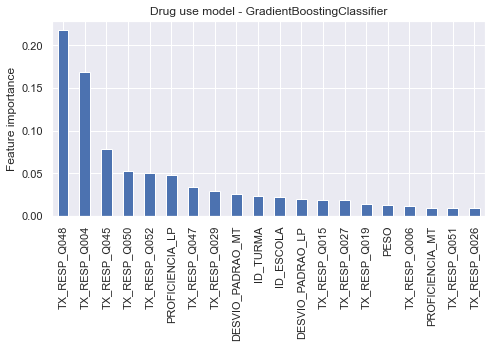

In [128]:
first, n_first = 1, 20
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
feature_importance.iloc[first-1:n_first].plot.bar(ax=ax);
plt.title(f'Drug use model - {model_name}');
plt.ylabel('Feature importance'); plt.show()

# Fitting and scoring baseline model up to max_features=15 most import features

In [129]:
RFI = recursive_feature_inclusion(x, xe, y, ye, feature_importance, max_features=30, first_feature=1)

Scoring model for 30/30 most important features.


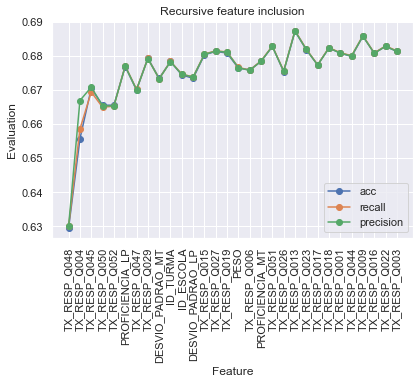

In [130]:
for rfe in [RFI]:
    fig, ax = plt.subplots(figsize=(6, 5.5), tight_layout=True)
    rfe.plot(marker='o', ax=ax)
    ax.set_xticks(range(len(rfe)))
    ax.set_xticklabels(rfe.index, rotation=90)
    ax.set(title='Recursive feature inclusion', xlabel='Feature', ylabel='Evaluation')
    plt.show()

# Classification report for baseline model of selected features

In [150]:
selected_features = feature_importance[:4].index.tolist()# + ['ID_MUNICIPIO', 'ID_ESCOLA', 'ID_TURMA']
xt_s = x[selected_features]; xe_s = xe[selected_features]
yp_sel = model().fit(xt_s, y).predict(xe_s)

print(cr(ye, yp_sel))

              precision    recall  f1-score   support

           0       0.70      0.63      0.66      3607
           1       0.66      0.72      0.68      3500

    accuracy                           0.68      7107
   macro avg       0.68      0.68      0.67      7107
weighted avg       0.68      0.68      0.67      7107



# Understanding selected features

In [142]:
selected = [
    'TX_RESP_Q004', 'TX_RESP_Q048',
    'TX_RESP_Q045', 'TX_RESP_Q050',
]

In [143]:
pd.concat([dicts[5].loc[[col]] for col in selected]).T.dropna(how='all').replace(np.nan, '')

questão,TX_RESP_Q004,TX_RESP_Q048,TX_RESP_Q045,TX_RESP_Q050
Enunciado,Qual a sua idade?,Você já foi reprovado?,Você trabalha fora de casa?,Você faz o dever de casa de língua portuguesa?
A,8 anos ou menos.,Não.,Sim.,Sempre ou quase sempre.
B,9 anos.,"Sim, uma vez.",Não.,De vez em quando.
C,10 anos.,"Sim, duas vezes ou mais.",,Nunca ou quase nunca.
D,11 anos.,,,
E,12 anos.,,,
F,13 anos.,,,
G,14 anos.,,,
H,15 anos ou mais,,,


---
# BINARY CLASSIFICATION MODELS USING NEURAL NETWORKS

In [14]:
import torch
import torch.nn as nn

### Resampling

In [19]:
### Sample students from random 20% of cities
### Train test split based on school classes
xt, xe_, yt, ye_ = tts_categorical(x_, y_, cnt, test_size=0.8, col='ID_MUNICIPIO')
print('Training classes count:\n', yt.value_counts())
print('\nTest percentage:\n', round(xe_.shape[0] / (xt.shape[0] + xe_.shape[0])*100, 1), '%')

Training classes count:
 1    10065
0    10065
Name: TX_RESP_Q049, dtype: int64

Test percentage:
 79.9 %


In [20]:
from sklearn.model_selection import train_test_split as tts
x, xe, y, ye = tts(xt, yt, test_size=0.3, random_state=999)
### Train test split based on school classes
# xt, _xe, yt, _ye = tts_categorical(x, y, cnt, test_size=0.75, col='ID_MUNICIPIO')
print('Training classes count:\n', y.value_counts())
print('\nTest percentage:\n', round(xe.shape[0] / (x.shape[0] + xe.shape[0])*100, 1), '%')

Training classes count:
 0    7105
1    6986
Name: TX_RESP_Q049, dtype: int64

Test percentage:
 30.0 %


In [23]:
x.shape, xe.shape

((14091, 68), (6039, 68))

In [38]:
nn_params = {
#     'test_size': 0.3,
    'hidden_layers': [68*10],
    'initial_params': {'weight': 0, 'bias': 0},
    # 'criterion': None
    'optimizer': torch.optim.SGD,
    'activation': 'sigmoid',
    'epochs': 80,
    'batch_size': 1000,
    'lr': 1,
    'momentum': 0,
}

criteria_dict = {
    'BCELoss': nn.BCELoss,
#     'L1Loss': nn.L1Loss,
#     'MSELoss': nn.MSELoss,
#     'HuberLoss': nn.HuberLoss
}

eval_i = {}
for label, criteria in criteria_dict.items():
    eval_i[label] = execute_neural_net(
        x, y, xe, ye,
        criterion=criteria,
        **nn_params,
    )

Epoch: 80/80


### Comparing neural network test predictions for different loss functions

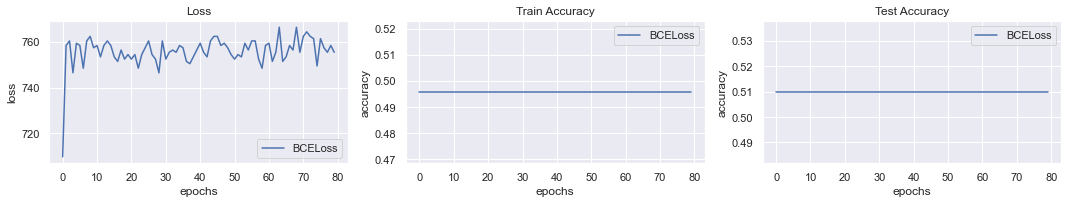

In [39]:
plot_learning_curve_comparison(eval_i, figsize=(15,3), tight_layout=True, legend=True)

In [758]:
grades

['PESO',
 'PROFICIENCIA_LP',
 'DESVIO_PADRAO_LP',
 'PROFICIENCIA_LP_SAEB',
 'DESVIO_PADRAO_LP_SAEB',
 'PROFICIENCIA_MT',
 'DESVIO_PADRAO_MT',
 'PROFICIENCIA_MT_SAEB',
 'DESVIO_PADRAO_MT_SAEB']